In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Understanding the data

Let's start by loading the data and parse the date column. Note that since the dates are in ISO format, using `utc=True` will allow us to have a more consistent format accross timezones.
The data has 6 column and represents all of the transactions that went through a bakery store in France. Each transaction represent a bill of a customer and can contain more than one sale. This means that if a customer comes at a store and buys two different items, we will get a row on the data for each of the item and they will both refer to the same transaction. The `quantity` column refer to to amount purchased for the item, and the `price_ht` and `price_ttc` respectively refer to the total price of the row without VAT and with VAT. The `date` column is the transaction timestamp.


In [18]:
df = pd.read_csv('transactions_ds.csv', sep=';')
df['date'] = pd.to_datetime(df['date'], utc=True)
df


,item_id,quantity,price_ht,price_ttc,transaction_id,date
0,0,1.0,12.42,13.1,1,2018-03-08 13:10:59+00:00
1,1,1.0,12.42,13.1,1,2018-03-08 13:10:59+00:00
2,2,1.0,12.42,13.1,1,2018-03-08 13:10:59+00:00
3,3,1.0,12.42,13.1,1,2018-03-08 13:10:59+00:00
4,1,1.0,11.56,12.2,2,2018-03-08 13:12:07+00:00
...,...,...,...,...,...,...
458725,11,1.0,1.14,1.2,311970,2022-08-18 18:38:26+00:00
458726,45,1.0,5.02,5.3,311972,2022-08-18 18:43:42+00:00
458727,11,1.0,5.02,5.3,311972,2022-08-18 18:43:42+00:00
458728,11,1.0,1.14,1.2,311973,2022-08-18 18:47:43+00:00


Then, we need to remove duplicate rows and we use the join index `(item_id,transaction_id)` to do that. We can see that this process actually removes around 16k rows from the data.


In [19]:
df = df.groupby(['item_id', 'transaction_id'], as_index=False).first()
df


,item_id,transaction_id,quantity,price_ht,price_ttc,date
0,0,1,1.0,12.42,13.10,2018-03-08 13:10:59+00:00
1,0,3,1.0,10.05,10.60,2018-03-08 13:12:18+00:00
2,0,7,1.0,0.00,0.00,2018-03-08 13:16:50+00:00
3,0,16,1.0,12.23,12.90,2018-03-08 14:21:13+00:00
4,0,32,1.0,12.23,12.90,2018-03-08 14:56:08+00:00
...,...,...,...,...,...,...
442188,106,311490,1.0,17.91,18.90,2022-08-17 14:29:57+00:00
442189,106,311525,1.0,5.02,5.30,2022-08-17 16:27:09+00:00
442190,106,311526,1.0,10.71,11.30,2022-08-17 16:31:40+00:00
442191,106,311596,1.0,5.02,5.30,2022-08-17 18:11:53+00:00


# Working on daily individual item sales.

Now, let's start by looking at individual sales of items. The data we have can allow us to get time series of the sales of a specific item. In order to choose a relevant item, we can order all of the `item_id` by popularity and look at the data of the most popular one (defined by the total amount of quantity sold).


In [22]:
popular_items = df.groupby(
    'item_id')['quantity'].sum().sort_values(ascending=False)
popular_items


item_id
11     78278.500
55     46318.000
38     29940.000
40     26009.500
26     21942.000
         ...    
103        3.095
79         3.000
77         3.000
98         2.000
84         1.000
Name: quantity, Length: 107, dtype: float64

Then, we can extract the sales of one item and resample the data to get the total number of sales both per day and per hour.


<Axes: xlabel='date'>

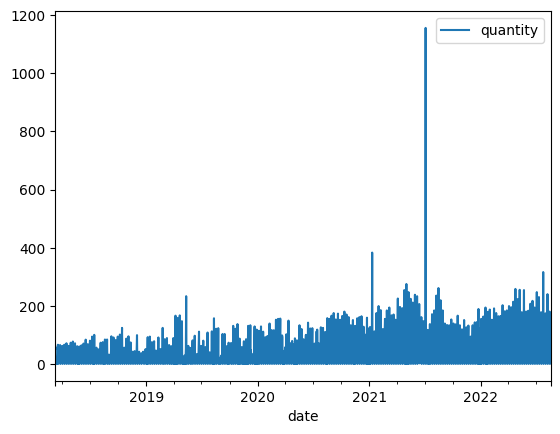

In [28]:
# create one dataframe for the most popular item
item_df = df[df['item_id'] == popular_items.index.values[0]]

# create daily and hourly resampled data
daily_item_df = item_df.set_index('date').resample('D')[['quantity']].sum()
hourly_item_df = item_df.set_index('date').resample('60min')[
    ['quantity']].sum()

# plot the daily data
daily_item_df.plot()


The first thing we notice is that the data has a lot of outliers, with days where the sales actually spike. For the moment we can simply try to remove these day to get a better sense of the true sales. Later, we will implement algorithms to replace the days with anormal sales by a relevant number.
To filter the outliers, we will use the z-score method, which assumes that the data is approximately normally distributed and that all of the outliers are actually at the far ends of the distribution curve. Hence, if we keep only the values close to the mean of the data, we can filter the outliers. In this case, we choose to keep centered values smaller than 2.5 times the standart deviation of the data, which essentially keeps 99% of the data in the case of a normal distribution.


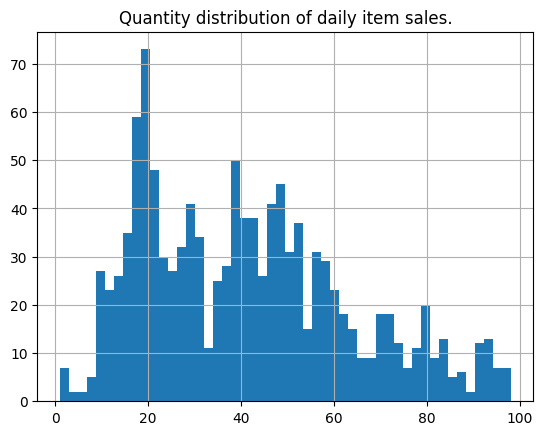

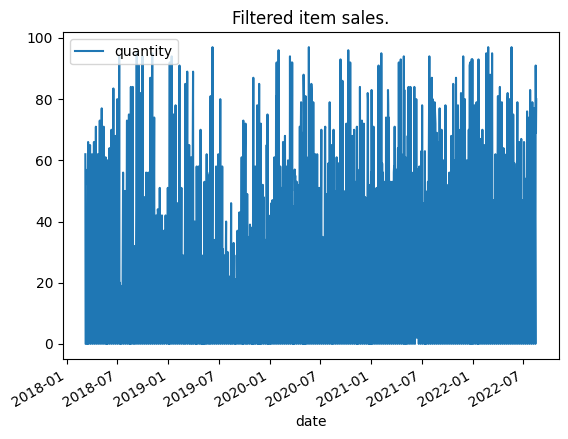

In [36]:
# first let's see the distribution of the data
daily_item_df[daily_item_df['quantity'] > 0].hist(bins=50)
plt.title('Quantity distribution of daily item sales')
plt.show()

# create the z-score filter function
def z_score_filter(data: pd.DataFrame, key: str):
    mean, std = data[key].mean(), data[key].std()
    return data[(data[key] - mean).abs() < 2.5*std]


# apply the function and plot the result
daily_item_df = z_score_filter(daily_item_df, 'quantity')

daily_item_df.plot()
plt.title('Filtered item sales')
plt.show()


Another thing that we can notice is that the actual sales distribution is closed to a sum of normal distributions. This can actually be due to the fact that since the sales are dependent of the day of the week, each sub time series filtered by the weekday may have an independant distribution with a different mean.


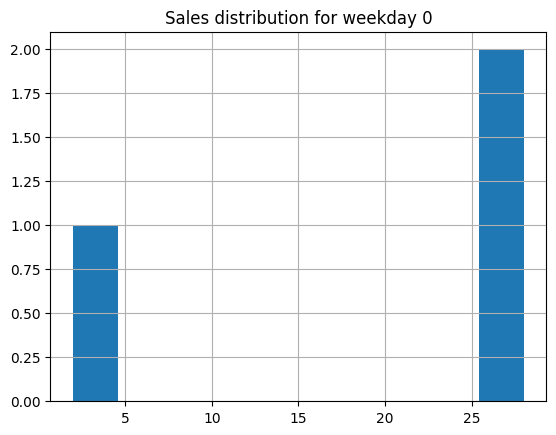

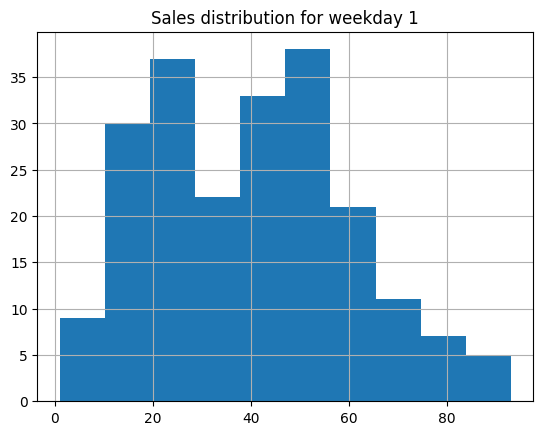

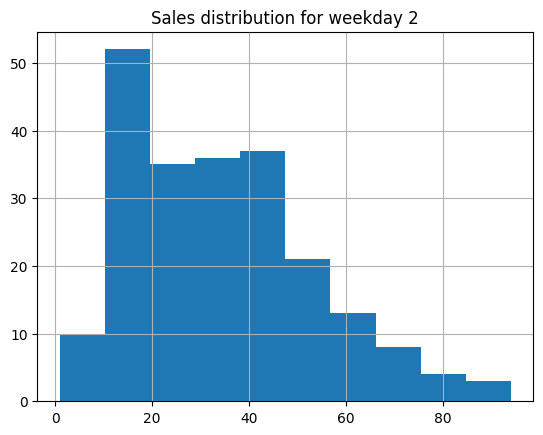

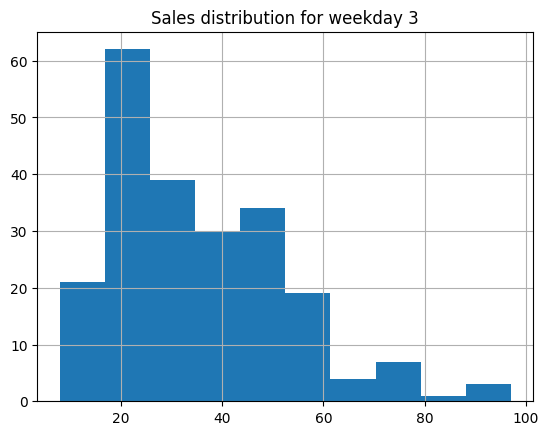

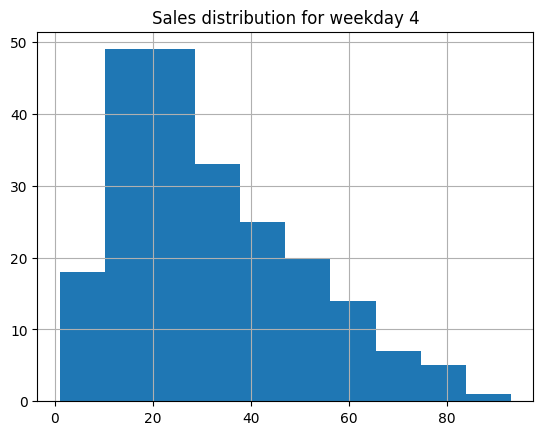

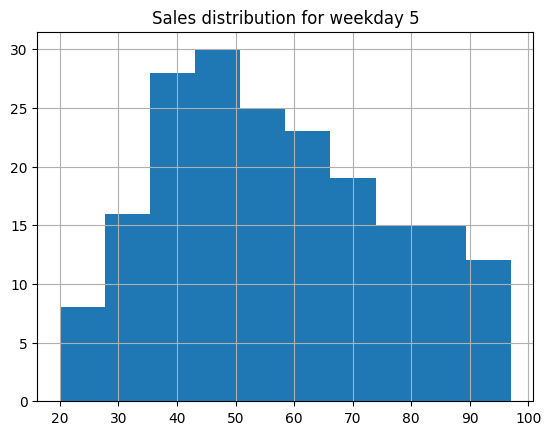

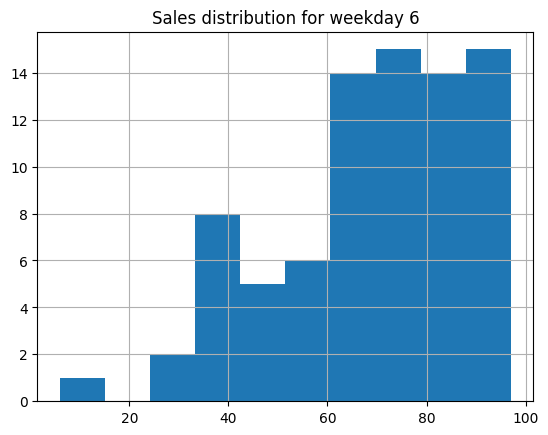

In [42]:
# add a weekday column
daily_item_df['weekday'] = daily_item_df.index.weekday

# look at each sub-timeserie
for k in range(7):
    weekday_item_df = daily_item_df[
        (daily_item_df['weekday'] == k) & (daily_item_df['quantity'] > 0)
    ]
    weekday_item_df['quantity'].hist(bins=10)
    plt.title(f'Sales distribution for weekday {k}')
    plt.show()
